In [1]:
# setwd('/Users/jifu/GitHub/Courses/UIUC_Courses/UIUC_STAT542/Walmart_Store/')
options(warn=-1)

# import required library
if (!require(lubridate)) {
    install.packages('lubridate')
}
if (!require(forecast)) {
    install.packages('forecast')
}
if (!require(MASS)) {
    install.packages('MASS')
}

library(MASS)
library(lubridate)  # convert date information
library(forecast)  # make forecast

Loading required package: lubridate

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: forecast
Loading required package: MASS


# Test

In [2]:
# load the data
train = read.csv('./train.csv')
test = read.csv('./test.csv')

# transform into numerical value
train$IsHoliday = as.numeric(train$IsHoliday)
test$IsHoliday = as.numeric(test$IsHoliday)

# transform the date
train$Date = as.Date(train$Date, '%Y-%m-%d')
test$Date = as.Date(test$Date, '%Y-%m-%d')

# get the year and month information
train$year = year(train$Date)
test$year = year(test$Date)

train$month = month(train$Date)
test$month = month(test$Date)

# get week information
train.week = train$Date
start_date = train.week[1]
train.week = train.week - start_date  # date is now 0, 7, 14, ...
train.week = train.week / 7 + 5  # make 2010-02-05 as '5'
train.week = as.numeric(train.week) %% 52  ## 52 weeks in a year
train$week = train.week

test.week = test$Date
test.week = test.week - start_date
test.week = test.week / 7 + 5  # make 2010-02-05 as '5'
test.week = as.numeric(test.week) %% 52
test$week = test.week

In [24]:
head(train)

Store,Dept,Date,Weekly_Sales,IsHoliday,year,month,week
1,1,2010-02-05,24924.50,0,2010,2,5
1,1,2010-02-12,46039.49,1,2010,2,6
1,1,2010-02-19,41595.55,0,2010,2,7
1,1,2010-02-26,19403.54,0,2010,2,8
1,1,2010-03-05,21827.90,0,2010,3,9
1,1,2010-03-12,21043.39,0,2010,3,10


In [29]:
for (i in sort(unique(train$Dept))) {
    tmp = train[train$Dept == 1, ]

    model = lm(Weekly_Sales ~ week + IsHoliday, data=tmp)

    value = boxcox(model, plotit=FALSE)
    cat(value$x[which.max(value$y)], ' ')
}

0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  

[1] 2925    8


Call:
lm(formula = Weekly_Sales ~ week + IsHoliday + month + Store, 
    data = tmp)

Residuals:
   Min     1Q Median     3Q    Max 
-25327  -8745  -3511   4172 146848 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 24793.30     781.86  31.711  < 2e-16 ***
week          223.97      52.81   4.241  2.3e-05 ***
IsHoliday    2576.66    1210.97   2.128  0.03344 *  
month        -602.29     228.00  -2.642  0.00829 ** 
Store        -277.77      22.52 -12.337  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15810 on 2920 degrees of freedom
Multiple R-squared:  0.05881,	Adjusted R-squared:  0.05752 
F-statistic: 45.61 on 4 and 2920 DF,  p-value: < 2.2e-16


[1] 0.2

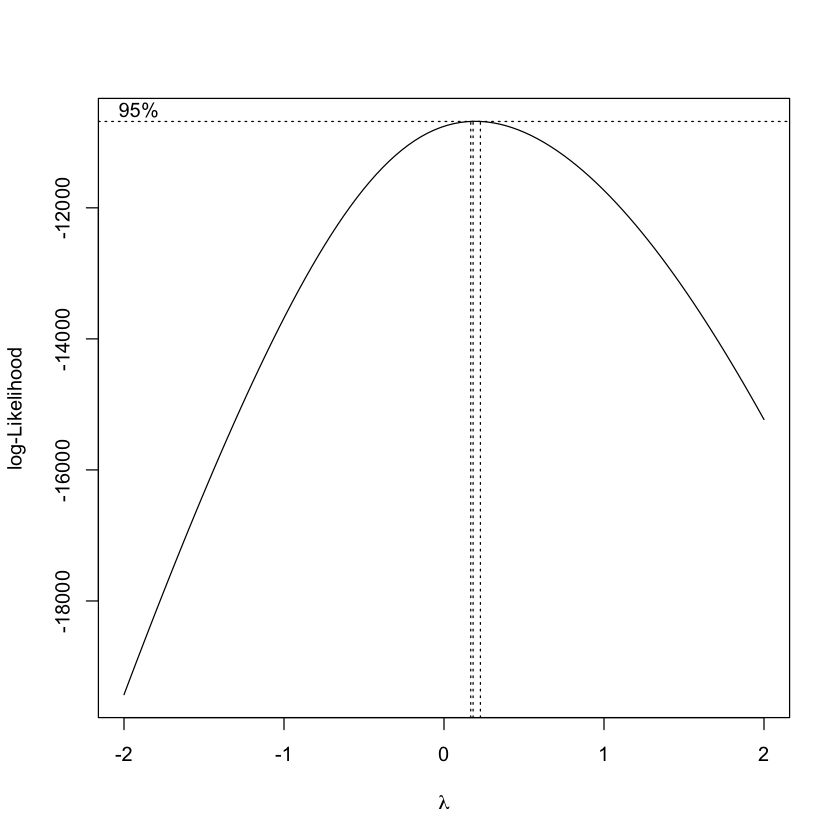

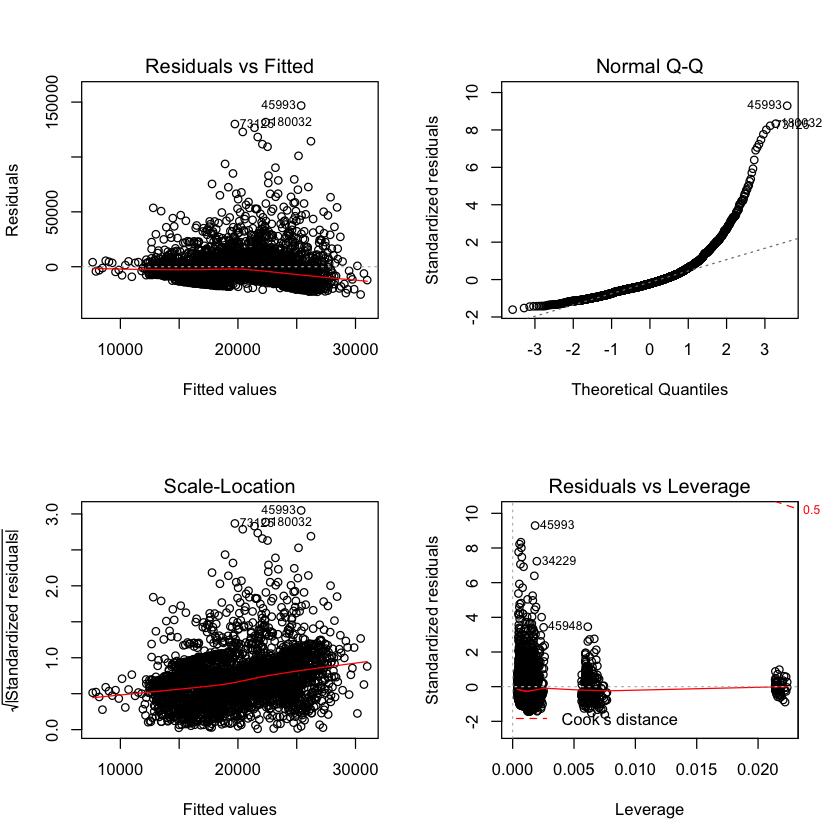

In [48]:
# tmp = train[train$Dept == 1 & train$Store == 1, ]
tmp = train[train$Dept == 1, ]
dim(tmp)

model = lm(Weekly_Sales ~ week + IsHoliday + month + Store, data=tmp)
summary(model)

boxcox(model)
value = boxcox(model, plotit=FALSE)
value$x[which.max(value$y)]

par(mfrow=c(2,2)) # Change the panel layout to 2 x 2
plot(model)


Call:
lm(formula = Weekly_Sales^0.2 ~ week + IsHoliday, data = tmp)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2869 -0.5704 -0.0542  0.5956  4.0527 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6.840068   0.035363 193.427  < 2e-16 ***
week        0.005016   0.001284   3.905 9.62e-05 ***
IsHoliday   0.126729   0.070950   1.786   0.0742 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.02 on 2922 degrees of freedom
Multiple R-squared:  0.005968,	Adjusted R-squared:  0.005288 
F-statistic: 8.772 on 2 and 2922 DF,  p-value: 0.0001591


[1] 1

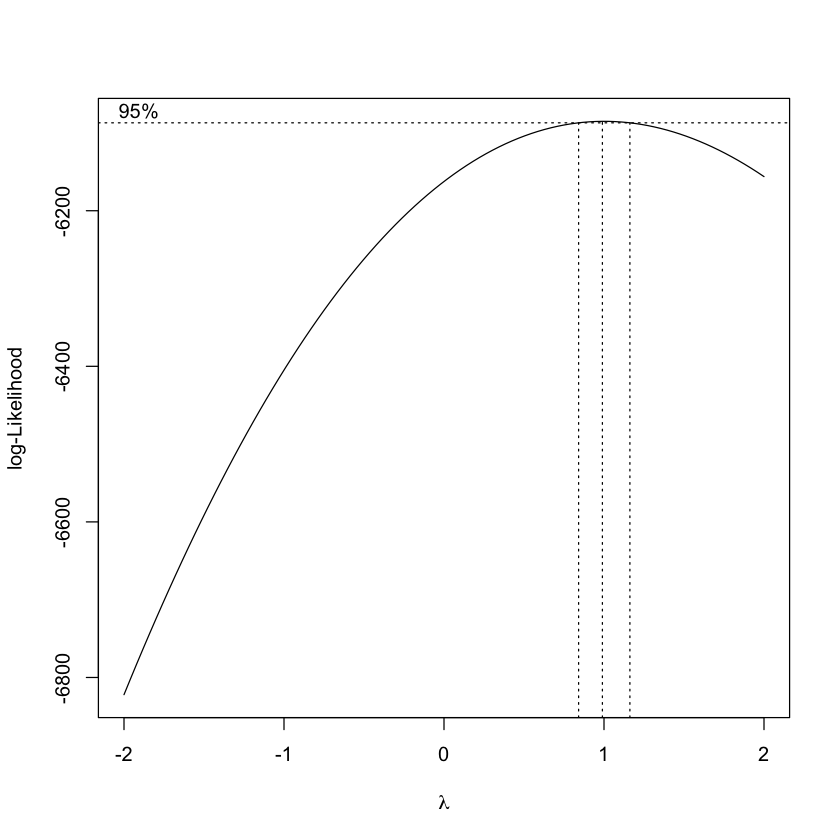

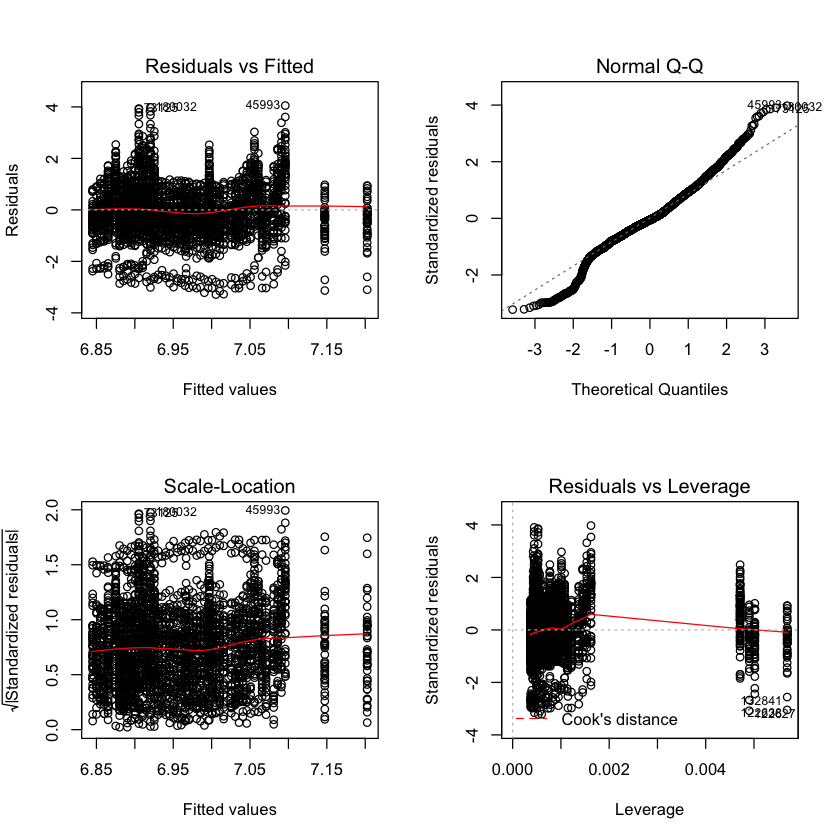

In [49]:
model = lm(Weekly_Sales ^ 0.2 ~ week + IsHoliday, data=tmp)
summary(model)

boxcox(model)
value = boxcox(model, plotit=FALSE)
value$x[which.max(value$y)]

par(mfrow=c(2,2)) # Change the panel layout to 2 x 2
plot(model)


Call:
lm(formula = Weekly_Sales^0.2 ~ week + IsHoliday + month + Store, 
    data = tmp)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0764 -0.5518 -0.0149  0.5512  3.8861 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.361809   0.048528 151.701  < 2e-16 ***
week         0.014318   0.003278   4.368  1.3e-05 ***
IsHoliday    0.222990   0.075163   2.967  0.00303 ** 
month       -0.043360   0.014151  -3.064  0.00220 ** 
Store       -0.020980   0.001398 -15.013  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9816 on 2920 degrees of freedom
Multiple R-squared:  0.07994,	Adjusted R-squared:  0.07868 
F-statistic: 63.43 on 4 and 2920 DF,  p-value: < 2.2e-16


[1] 1

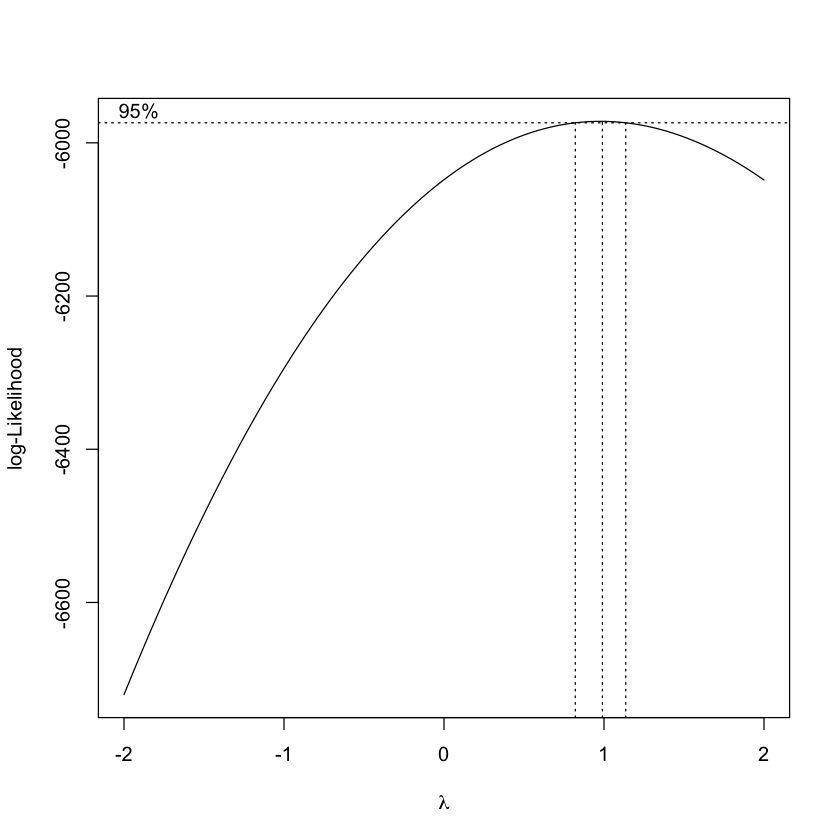

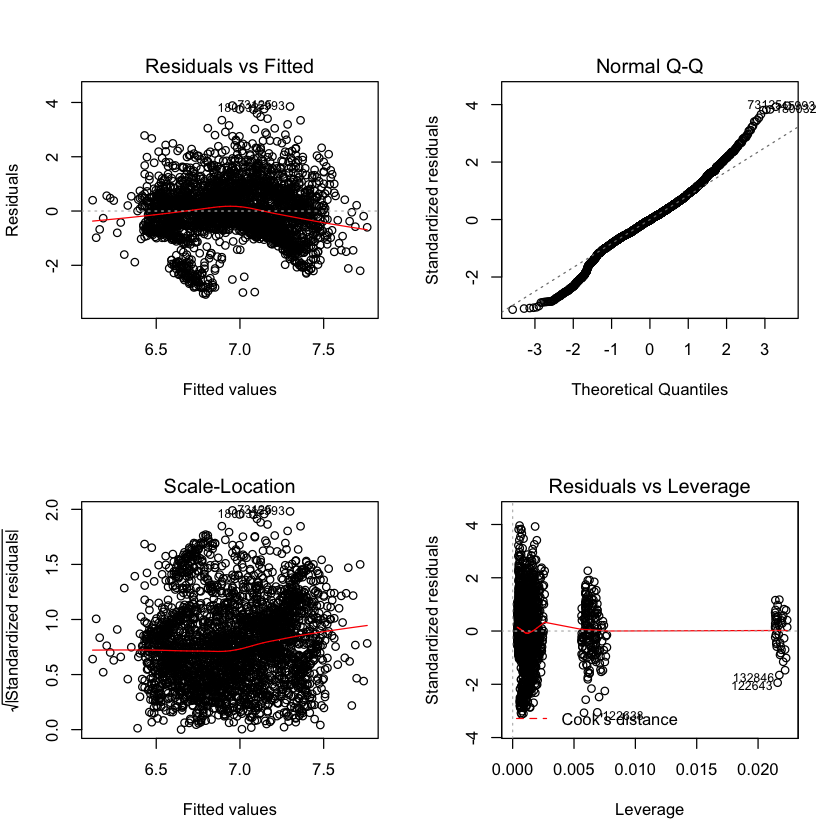

In [50]:
model = lm(Weekly_Sales ^ 0.2 ~ week + IsHoliday + month + Store, data=tmp)
summary(model)

boxcox(model)
value = boxcox(model, plotit=FALSE)
value$x[which.max(value$y)]

par(mfrow=c(2,2)) # Change the panel layout to 2 x 2
plot(model)

# Model 1

* use the information from the previous year
* the same department, same store
* week - 1, week, week + 1

In [ ]:
# load the data
train = read.csv('./train.csv')
test = read.csv('./test.csv')

# transform into numerical value
train$IsHoliday = as.numeric(train$IsHoliday)
test$IsHoliday = as.numeric(test$IsHoliday)

# transform the date
train$Date = as.Date(train$Date, '%Y-%m-%d')
test$Date = as.Date(test$Date, '%Y-%m-%d')

# get the year and month information
train$year = year(train$Date)
test$year = year(test$Date)

train$month = month(train$Date)
test$month = month(test$Date)

# get week information
train.week = train$Date
start_date = train.week[1]
train.week = train.week - start_date  # date is now 0, 7, 14, ...
train.week = train.week / 7 + 5  # make 2010-02-05 as '5'
train.week = as.numeric(train.week) %% 52  ## 52 weeks in a year
train$week = train.week

test.week = test$Date
test.week = test.week - start_date
test.week = test.week / 7 + 5  # make 2010-02-05 as '5'
test.week = as.numeric(test.week) %% 52
test$week = test.week

start.time = Sys.time()  # get time information

for (t in 1:20) {
    month = 2 + t
    year = 2011
    if (month > 12) {
        month = month - 12
        year = 2011 + 1
    }
    
    # get the tmp test data
    tmp.test = test[(test$year == year) & (test$month == month), ]
    
    # get the length of unique store and department
    store = sort(unique(tmp.test$Store))
    n.store = length(store)
    dept = sort(unique(tmp.test$Dept))
    n.dept = length(dept)
    
    # ------------------------------------------
    #             model 1
    # ------------------------------------------
    
    # choose the median value from the last year, in week-1, week, and week+1
    for (s in 1:n.store){
        for (d in 1:n.dept){
            # find the data for (store, dept) = (s, d)
            test.id = which(test$Store == store[s] & test$Dept == dept[d] &
                            test$year == year & test$month == month)
            test.temp = test[test.id, ]
            train.id = which(train$Store == store[s] & train$Dept == dept[d])
            train.temp = train[train.id, ]
            
            # ------------------------------------------
            #             model 1
            # ------------------------------------------
            for (i in 1:length(test.id)){
                id.1 = which(train.temp$week == test.temp[i,]$week - 1 & 
                             train.temp$year == test.temp[i,]$year - 1)
                id.2 = which(train.temp$week == test.temp[i,]$week & 
                             train.temp$year == test.temp[i,]$year - 1)
                id.3 = which(train.temp$week == test.temp[i,]$week + 1 & 
                             train.temp$year == test.temp[i,]$year - 1)
                id = c(id.1, id.2, id.3)
                
                # three weeks in the last year
                tempSales = train.temp[id, 'Weekly_Sales']
                
                if (length(tempSales) == 0){
                    test$Weekly_Pred1[test.id[i]] = 0
                }else{
                    test$Weekly_Pred1[test.id[i]] = median(tempSales)
                }
            } 
        }
    }
    
    # ------------------------------------------
    #             model 2
    # ------------------------------------------
    for (d in 1:n.dept){
        # find the data for dept = d
        test.id = which(test$Dept == dept[d] & test$year == year & test$month == month)
        test.temp = test[test.id, ]
        train.id = which(train$Dept == dept[d])
        train.temp = train[train.id, ]
        
        # fit a linear model
        model = lm(Weekly_Sales ^ 0.2 ~ week + IsHoliday + month + Store, data=train.temp)
        # make prediction
        predicted = predict(model, test.temp)
        test$Weekly_Pred2[test.id] = predicted ^ 5
    }
    
    # read new input file
    tmp.filename = paste('xxx', t, '.csv', sep='');
    newtest = read.csv(tmp.filename)
    
    # transform the date
    newtest$Date = as.Date(newtest$Date, '%Y-%m-%d')

    # get the year and month information
    newtest$year = year(newtest$Date)
    newtest$month = month(newtest$Date)
    
    # process the date
    tmp.week = newtest$Date
    tmp.week = tmp.week - start_date
    tmp.week = tmp.week / 7 + 5  # make 2010-02-05 as '5'
    tmp.week = as.numeric(tmp.week) %% 52
    newtest$week = tmp.week
    
    # merge together
    train = rbind(train, newtest[, names(train)])
}

end.time = Sys.time()
cat('Total used time is:\t', end.time - start.time, '\n')

# NA values

In [4]:
head(test, 10)

Store,Dept,Date,Weekly_Sales,IsHoliday,Weekly_Pred1,Weekly_Pred2,Weekly_Pred3,year,month,week
1,1,2011-03-04,20327.61,0,21043.39,20320.60,0,2011,3,9
1,1,2011-03-11,21280.40,0,21827.90,20512.48,0,2011,3,10
1,1,2011-03-18,20334.23,0,22136.64,20705.81,0,2011,3,11
1,1,2011-03-25,20881.10,0,26229.21,20900.59,0,2011,3,12
1,1,2011-04-01,20398.09,0,42960.91,20466.44,0,2011,4,13
1,1,2011-04-08,23873.79,0,42960.91,20662.21,0,2011,4,14
1,1,2011-04-15,28762.37,0,17596.96,20859.47,0,2011,4,15
1,1,2011-04-22,50510.31,0,16555.11,21058.23,0,2011,4,16
1,1,2011-04-29,41512.39,0,16555.11,21258.51,0,2011,4,17
1,1,2011-05-06,20138.19,0,17413.94,21917.93,0,2011,5,18


In [5]:
head(which(is.na(test$Weekly_Pred1)))

integer(0)

# Performance test
* According to the definition of the weighted mean absolute error (WMAE)
* Link to Kaggle: [Walmart Recruiting - Store Sales Forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting#evaluation)

In [6]:
# define weight w
weight = 4 * test$IsHoliday + 1

# calculate the performance of different models
WMAE1 = sum(weight * abs(test$Weekly_Pred1 - test$Weekly_Sales)) / sum(weight)
WMAE2 = sum(weight * abs(test$Weekly_Pred2 - test$Weekly_Sales)) / sum(weight)
WMAE3 = sum(weight * abs(test$Weekly_Pred3 - test$Weekly_Sales)) / sum(weight)

# output the performance of different models
cat(WMAE1, '\t', WMAE2, '\t', WMAE3, '\n')

13816.54 	 14983.3 	 16168.23 


# Model 2

* use the information from the previous years
* the same department, but different stores
* use the median of the same week

In [15]:
# # get the length of unique department
# dept = sort(unique(test$Dept))
# n.dept = length(dept)

In [16]:
# # choose the median value from the last year, in week - 1, week, and week + 1
# for (d in 1:n.dept){
# #     cat("Department: ", dept[d], "\n")
#     # find the data for (store, dept) = (s, d)
#     test.id = which(test$Dept == dept[d])
#     test.temp = test[test.id, ]
#     train.id = which(train$Dept == dept[d])
#     train.temp = train[train.id, ]

#     for (i in 1:length(test.id)){
#         id = which(train.temp$week == test.temp[i,]$week & train.temp$year < test.temp[i,]$year)
#         tempSales = train.temp[id, 'Weekly_Sales']
#         if (length(tempSales) == 0){
#             test$Weekly_Pred2[test.id[i]] = 0
#         }else{
#             test$Weekly_Pred2[test.id[i]] = median(tempSales)
#         }
#     }
# }

# Model 3

* use the information from the previous years
* the same department, same store
* use all weeks' information to make forecast

# Model 4

* not decided yet